<a href="https://colab.research.google.com/github/Sniper202/Detecccion-de-defectos-en-chips-de-papa/blob/main/Modelo%20U-%20Net%202/MODELOUNETDAUSAR_256_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
import PIL
from PIL import Image
import pandas as pd

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
PATH = '/content/drive/MyDrive/Model_UNet_potato_chips_defect'
train_path ='/content/drive/MyDrive/Model_UNet_potato_chips_defect/Data_Augmentation2'
train_mask_path = '/content/drive/MyDrive/Model_UNet_potato_chips_defect/Data_MaskD3'
test_path = '/content/drive/MyDrive/Model_UNet_potato_chips_v4/Test/Defective'

In [ ]:
class Potato_Dataset(Dataset):
    def __init__(self,data, masks = None, img_transforms = None, mask_transforms = None) :

        self.train_data = data # train data path
        self.train_mask = masks #train masks path

        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_mask))

    def __len__(self):
        if self.train_mask is not None:
            assert len(self.images) == len(self.masks)
        return len(self.images)

    def __getitem__(self, index):
        image_name = os.path.join(self.train_data, self.images[index])
        img = Image.open(image_name)
        transf= T.ToTensor()
        if self.img_transforms:
            img = self.img_transforms(img)
        else:
            img = transf(img)


        if self.train_mask:
            mask_name = os.path.join(self.train_mask,self.masks[index])
            mask = Image.open(mask_name)
            if self.mask_transforms:
                mask = self.mask_transforms(mask)
            else:
                mask = transf(mask)

            mask_max = mask.max().item()
            mask /= mask_max

        else:
            return img

        return img, mask

In [ ]:
transform_data = T.Compose([
                    T. Resize([256,256]),
                    T.ToTensor()
                    ])

In [ ]:
#Dataloader
full_dataset = Potato_Dataset( train_path,
                                  train_mask_path,
                                  img_transforms = transform_data,
                                  mask_transforms = transform_data)

In [ ]:
#### NUEVO DATA

In [ ]:
BATCH_SIZE = 8
Train_size = int(len(full_dataset)*0.8)
Val_size = len(full_dataset) - Train_size
train_data, val_data = random_split(full_dataset,[Train_size,Val_size])
print (len(train_data), len(val_data))

257 65


In [ ]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_data,batch_size=BATCH_SIZE,shuffle=True)

imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

for i, (x, y) in enumerate(train_loader):
    print(i, x.shape, y.shape)
    if i==9:break

torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
0 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
1 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
2 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
3 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
4 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
5 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
6 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
7 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
8 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
9 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])


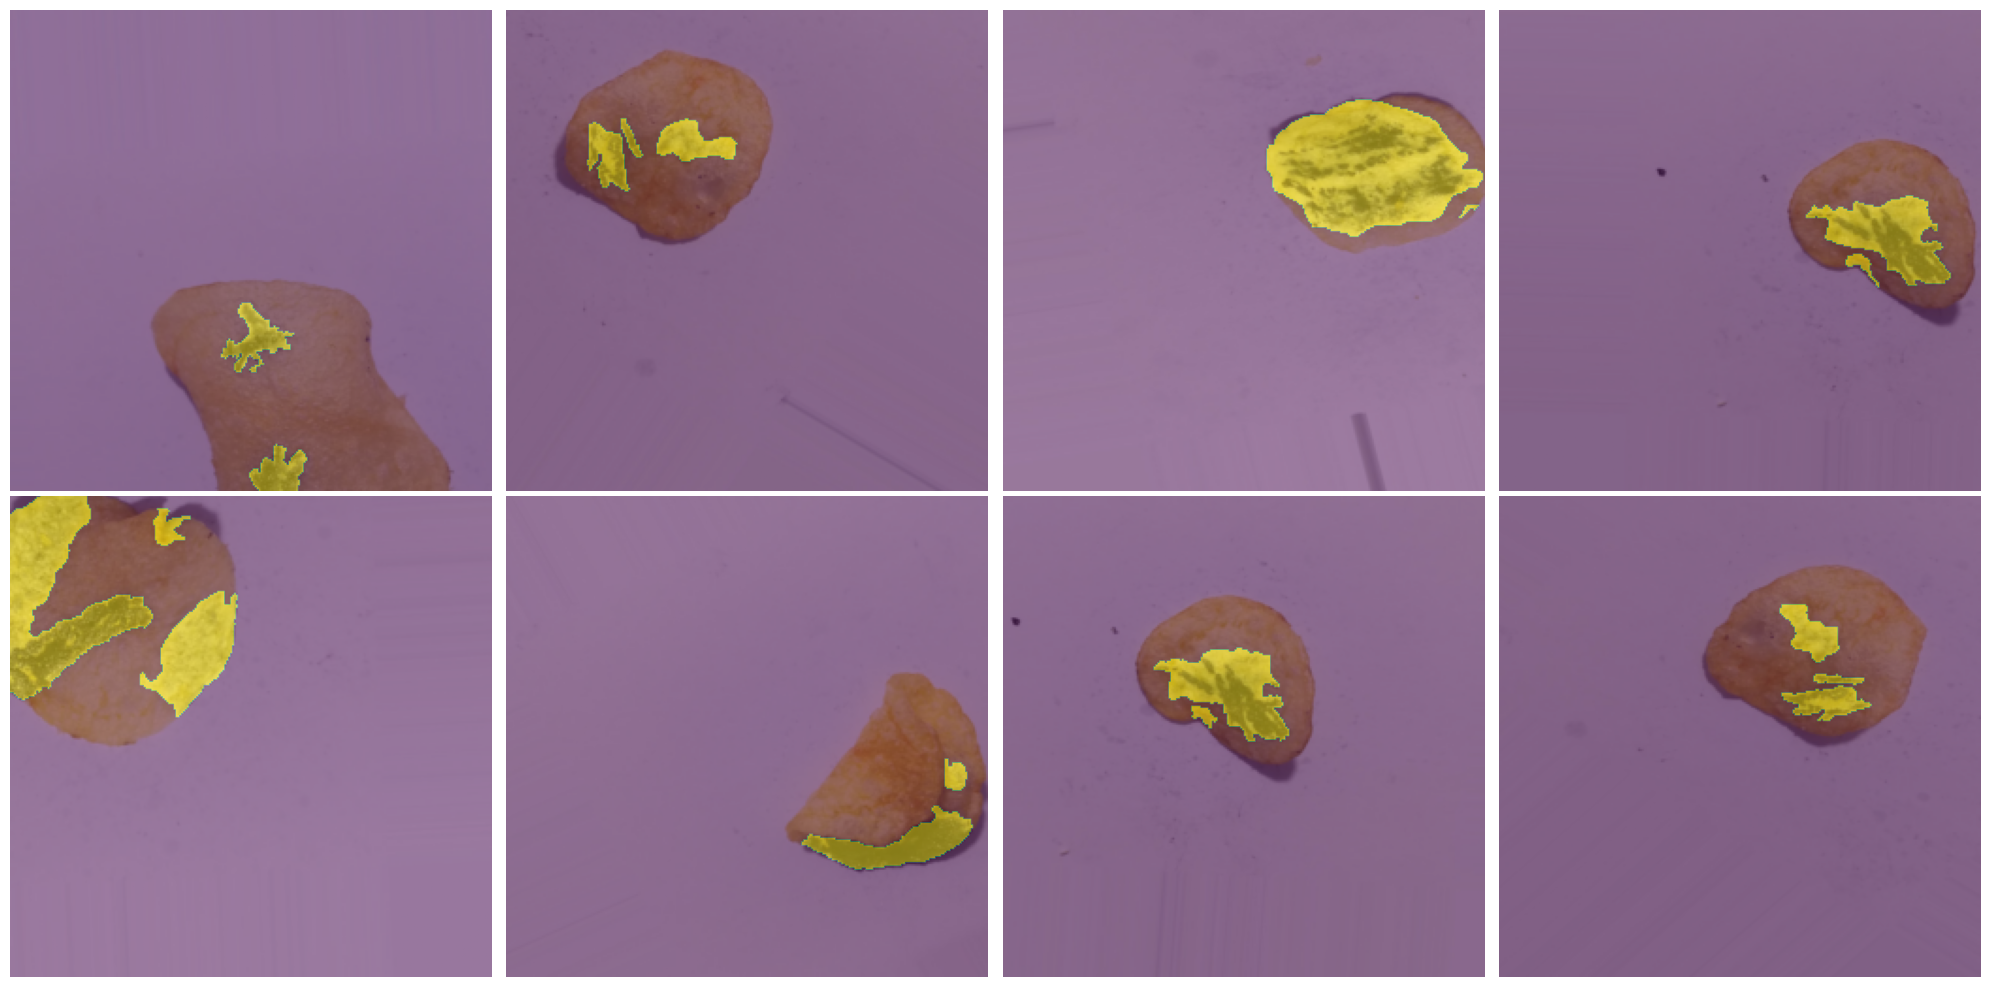

In [ ]:
imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs,masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(2,4,i+1)
        img = imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i,...].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)

        plt.axis('Off')
    plt.tight_layout()
    plt.show()
plot_mini_batch(imgs, masks)

In [ ]:
class Conv_3_k(nn.Module):
    def __init__(self,channels_in,channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in,channels_out, kernel_size=3,stride=1,padding=1)

    def forward(self, x ):
        return self.conv1(x)

class Double_Conv(nn.Module):

    def __init__(self,channels_in,channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
            Conv_3_k(channels_in,channels_out),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),
            Conv_3_k(channels_out,channels_out),
            nn.BatchNorm2d(channels_out),
            nn.ReLU()
        )

    def forward(self, x):
        return self.double_conv(x)

class Down_conv(nn.Module):

    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2,2),
            Double_Conv(channels_in,channels_out)
        )
    def forward(self,x):
        return self.encoder(x)


class Up_conv(nn.Module):

    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
            nn.Upsample(scale_factor=2,mode='bicubic'),
            nn.Conv2d(channels_in,channels_in//2,kernel_size=1,stride=1)
        )

        self.decoder = Double_Conv(channels_in,channels_out)

    def forward(self, x1, x2):
        x1 = self.upsample_layer(x1)
        x =  torch.cat([x2,x1],dim=1)
        return self.decoder(x)


class UNET_potato_model(nn.Module):


    def __init__(self, channels_in, channels, num_class ):
        super().__init__()
        self.f_conv = Double_Conv(channels_in, channels) # 8,256,256
        self.down_conv1 = Down_conv(channels, 2*channels) # 16, 128, 128
        self.down_conv2 = Down_conv(2*channels,4*channels) # 32, 64, 64
        self.down_conv3 = Down_conv(4*channels,8*channels) # 64,32,32

        self.middle_conv = Down_conv(8*channels,16*channels) # 128, 16 , 16

        self.up_conv1 = Up_conv(16*channels, 8*channels) # 64, 32 , 32
        self.up_conv2 = Up_conv(8*channels, 4*channels) # 32, 64 , 64
        self.up_conv3 = Up_conv(4*channels, 2*channels) # 16, 128 , 128
        self.up_conv4 = Up_conv(2*channels, channels) # 8, 256 , 256

        self.last_conv = nn.Conv2d(channels, num_class, kernel_size=1,stride=1)

    def forward(self, x):
        x1 = self.f_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)

        x5 = self.middle_conv(x4)

        x6 = self.up_conv1(x5,x4)
        x7 = self.up_conv2(x6,x3)
        x8 = self.up_conv3(x7,x2)
        x9 = self.up_conv4(x8,x1)


        return self.last_conv(x9)

In [ ]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)

        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)

        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())

        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr

    return log_lrs, losses, accuracies

In [ ]:
torch.manual_seed(42)
model = UNET_potato_model(3, 16, 3)
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

# optimiser_unet = torch.optim.Adam(model.parameters(), lr= 0.0001)

lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-6, end_val=10)

cost:1.0165, lr: 0.0000, acc: 0.2317
cost:0.9999, lr: 0.0000, acc: 0.2610
cost:1.0033, lr: 0.0000, acc: 0.2551
cost:1.0371, lr: 0.0000, acc: 0.2269
cost:1.0045, lr: 0.0000, acc: 0.2489
cost:1.0050, lr: 0.0000, acc: 0.2529
cost:1.0223, lr: 0.0000, acc: 0.2460
cost:1.0169, lr: 0.0000, acc: 0.2325
cost:1.0147, lr: 0.0001, acc: 0.2358
cost:0.9974, lr: 0.0001, acc: 0.2510
cost:0.9969, lr: 0.0002, acc: 0.2603
cost:0.9845, lr: 0.0003, acc: 0.2537
cost:0.9573, lr: 0.0004, acc: 0.2681
cost:0.9300, lr: 0.0007, acc: 0.2708
cost:0.9017, lr: 0.0012, acc: 0.2914
cost:0.8800, lr: 0.0019, acc: 0.3007
cost:0.8448, lr: 0.0032, acc: 0.3044
cost:0.7983, lr: 0.0052, acc: 0.3081
cost:0.7311, lr: 0.0087, acc: 0.3157
cost:0.6270, lr: 0.0143, acc: 0.3254
cost:0.4904, lr: 0.0237, acc: 0.3244
cost:0.3165, lr: 0.0392, acc: 0.3251
cost:0.2096, lr: 0.0649, acc: 0.3138
cost:0.2005, lr: 0.1075, acc: 0.3167
cost:0.2949, lr: 0.1778, acc: 0.3148
cost:0.3370, lr: 0.2943, acc: 0.3182
cost:0.2945, lr: 0.4870, acc: 0.3215
c

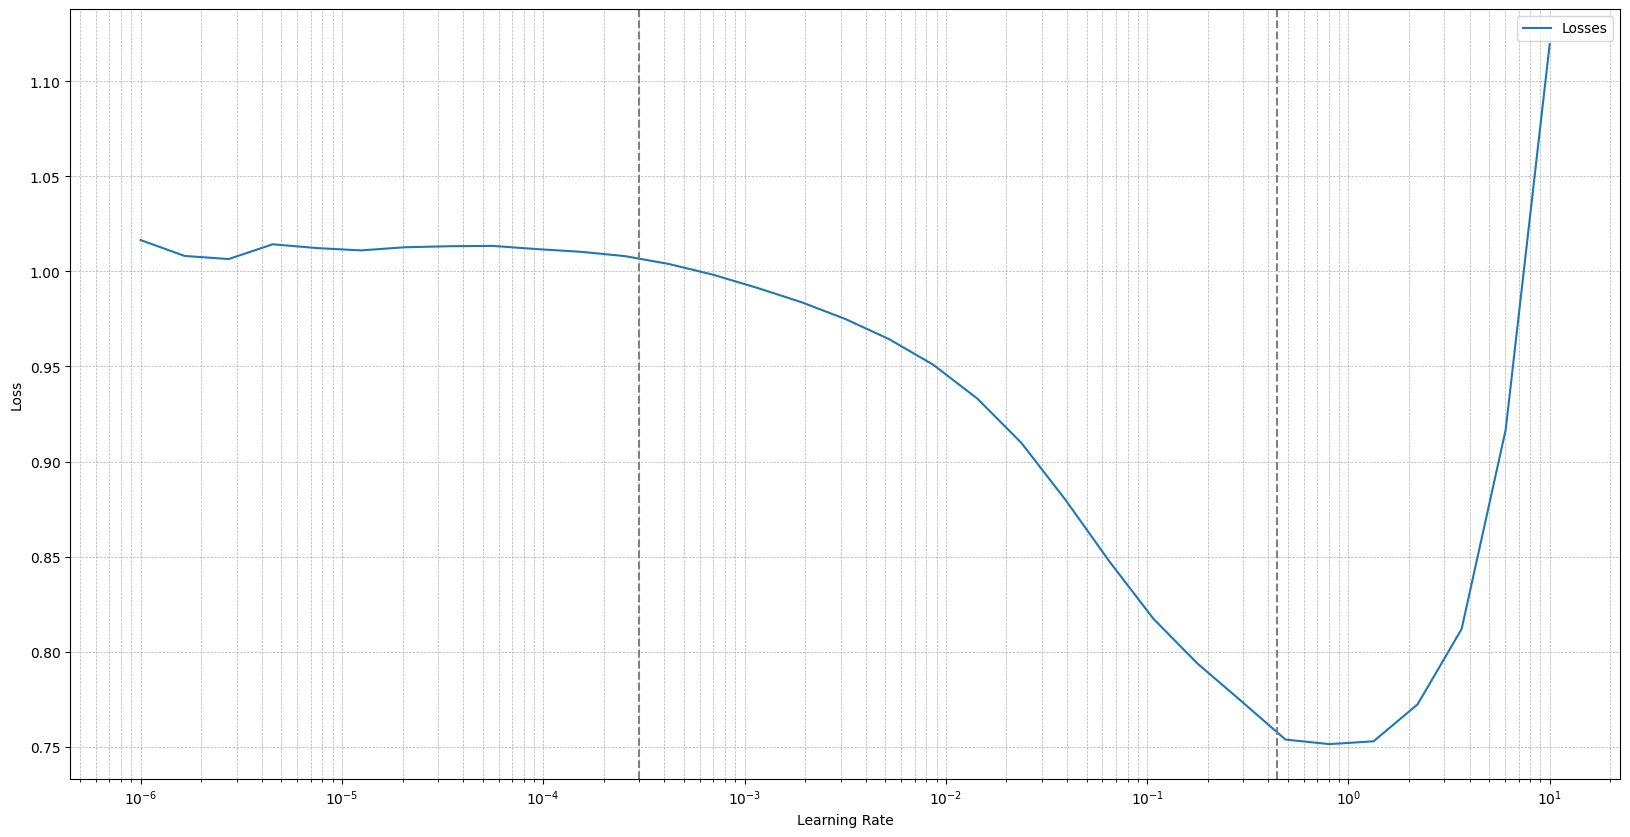

In [ ]:
p = (0.0003,0.4870)
fl, axl = plt.subplots(figsize =(20,10))
axl.plot(lg_lr, losses,label ='Losses')
axl.set_xscale('log')
axl.yaxis.set_major_locator(plt.MaxNLocator(nbins=10))
axl.set_xlabel('Learning Rate')
axl.set_ylabel('Loss')
axl.axvline(p[0], color='gray', linestyle='--')
axl.axvline(p[1], color='gray', linestyle='--')
axl.grid(True,which='both',linestyle ='--', linewidth = 0.5)
axl.legend()

plt.show()

torch.Size([8, 256, 256])


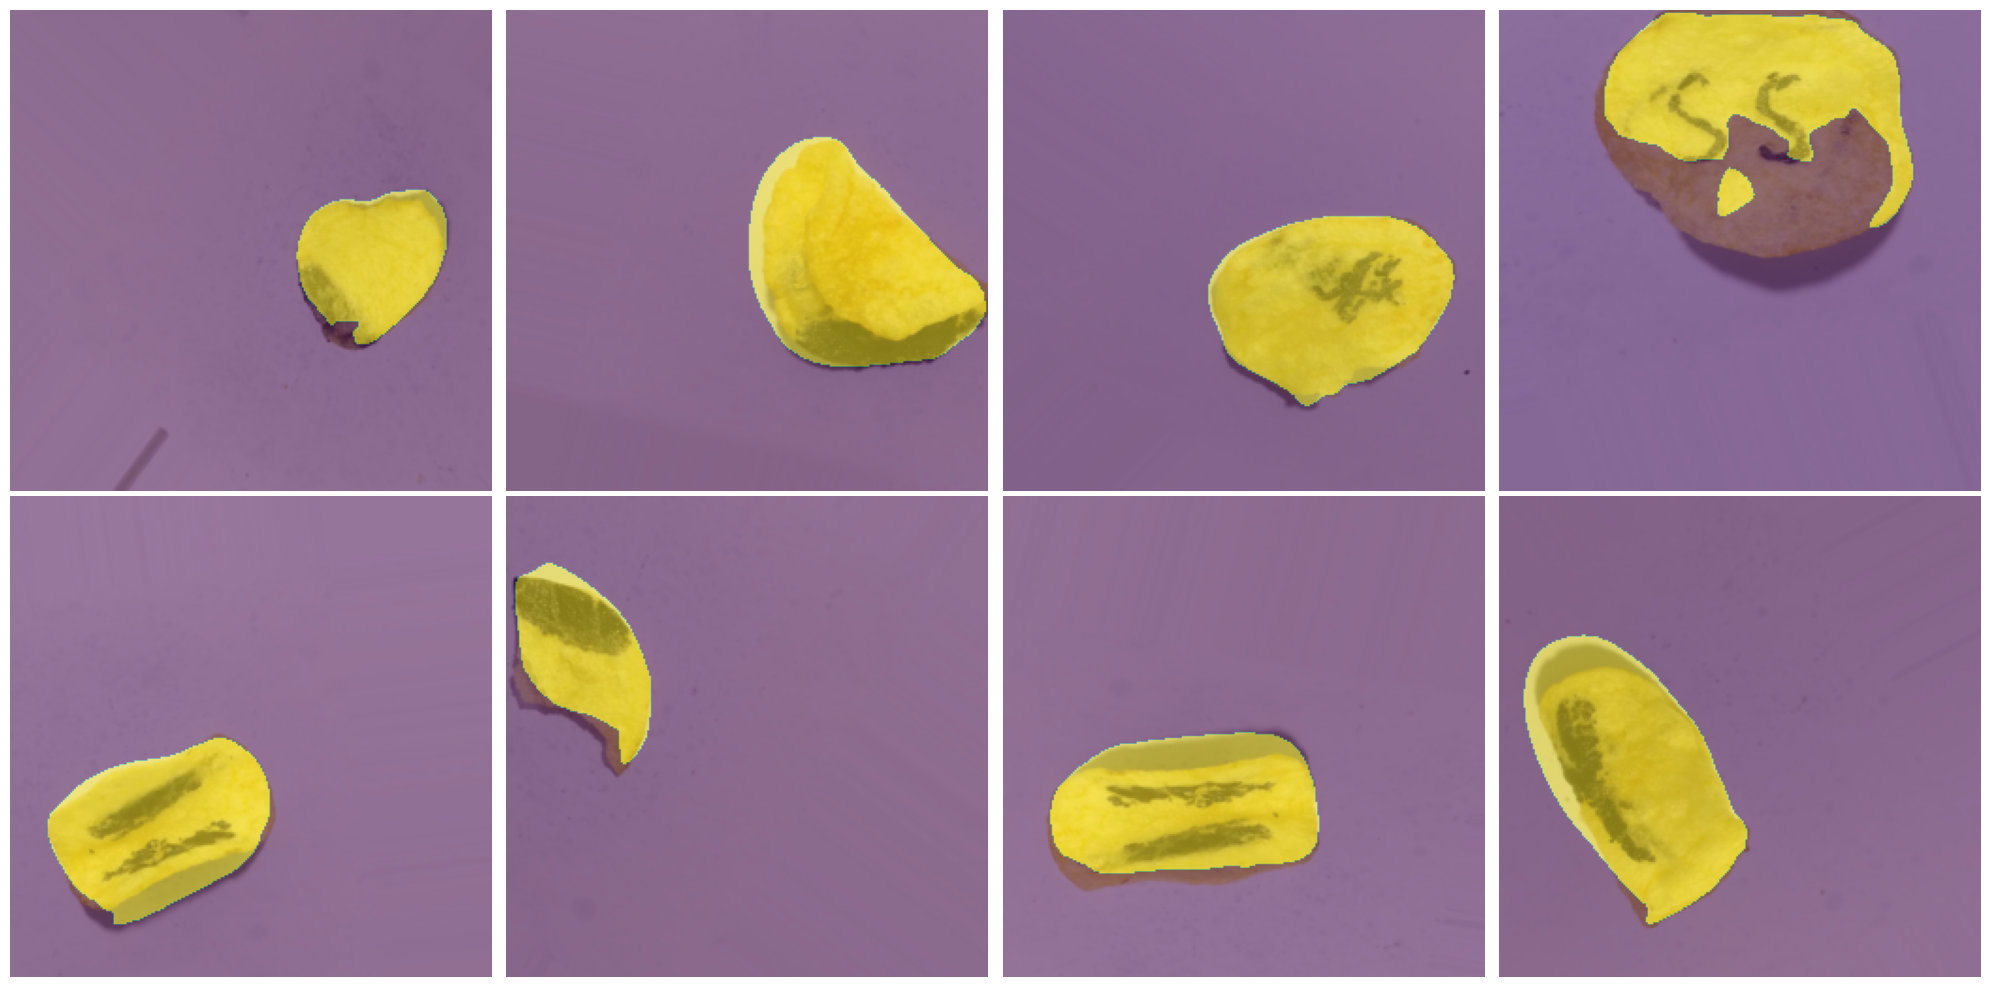

In [ ]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

In [ ]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)

        return cost/len(loader), float(correct)/total, dice, iou

In [ ]:
def train(model, optimiser, scheduler=None, epochs=100, store_every=15, save_path='best_model.pt'):
    model = model.to(device=device)

    train_loss_h, val_loss_h = [], []
    train_acc_h, val_acc_h = [], []
    train_IoU, val_dice = [], []

    best_val_acc = 0.0
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

            if scheduler:
                scheduler.step()

            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()

            if mb % store_every == 0:

                if train_total > 0:
                    train_acc = float(train_correct_num) / train_total
                else:
                    train_acc = 0.0

                train_cost_every = float(train_cost_acum) / mb

                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb

                val_loss_h.append(val_cost)
                val_acc_h.append(val_acc)

                train_loss_h.append(train_cost_every)
                train_acc_h.append(train_acc)
                train_IoU.append(iou)
                val_dice.append(dice)

                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice:.5f}, iou: {iou:.5f}')


                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    torch.save(model.state_dict(), save_path)

    return train_loss_h, train_acc_h, val_loss_h, val_acc_h, train_IoU, val_dice

In [ ]:
save_path = '/content/drive/MyDrive/Model_UNet_potato_chips_defect/modelos/modelo 1/UNETDEFECTV_2_new.pt'
store_every = 32
torch.manual_seed(42)
model = UNET_potato_model(3, 8, 3)
epochs = 100
optimiser_unet = torch.optim.Adam(model.parameters(), lr= 0.0001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet,
                                                max_lr = 0.0024,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [ ]:
train_loss_h, train_acc_h, val_loss_h, val_acc_h, train_IoU, val_dice = train(model, optimiser_unet, scheduler, epochs, store_every, save_path)

epoch: 0, mb: 32, train cost: 0.5742, val cost: 0.5079,train acc: 0.9600, val acc: 0.9802,dice: 0.67773, iou: 0.51256
epoch: 1, mb: 32, train cost: 0.4865, val cost: 0.4656,train acc: 0.9788, val acc: 0.9835,dice: 0.75482, iou: 0.60620
epoch: 2, mb: 32, train cost: 0.4485, val cost: 0.4285,train acc: 0.9806, val acc: 0.9856,dice: 0.78452, iou: 0.64544
epoch: 3, mb: 32, train cost: 0.4138, val cost: 0.3946,train acc: 0.9829, val acc: 0.9870,dice: 0.81595, iou: 0.68912
epoch: 4, mb: 32, train cost: 0.3823, val cost: 0.3639,train acc: 0.9831, val acc: 0.9853,dice: 0.79710, iou: 0.66264
epoch: 5, mb: 32, train cost: 0.3489, val cost: 0.3358,train acc: 0.9855, val acc: 0.9873,dice: 0.82838, iou: 0.70704
epoch: 6, mb: 32, train cost: 0.3167, val cost: 0.2988,train acc: 0.9860, val acc: 0.9878,dice: 0.83534, iou: 0.71724
epoch: 7, mb: 32, train cost: 0.2837, val cost: 0.2644,train acc: 0.9874, val acc: 0.9896,dice: 0.85498, iou: 0.74670
epoch: 8, mb: 32, train cost: 0.2504, val cost: 0.2340,t

In [ ]:

data = {
    'epoch': list(range(1, len(train_loss_h) + 1))
    'train_loss': train_loss_h,
    'train_acc': train_acc_h,
    'val_loss': val_loss_h,
    'val_acc': val_acc_h,
    'train_IoU': train_IoU,
    'val_dice': val_dice
}

df = pd.DataFrame(data)
excel_file_path = '/content/drive/MyDrive/Model_UNet_potato_chips_defect/modelos/modelo 1/UNETDEFECTV_2_new.xlsx'
df.to_excel(excel_file_path, index=False)

In [ ]:
test_set = Potato_Dataset(test_path, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=12, shuffle=True)

torch.Size([12, 256, 256])


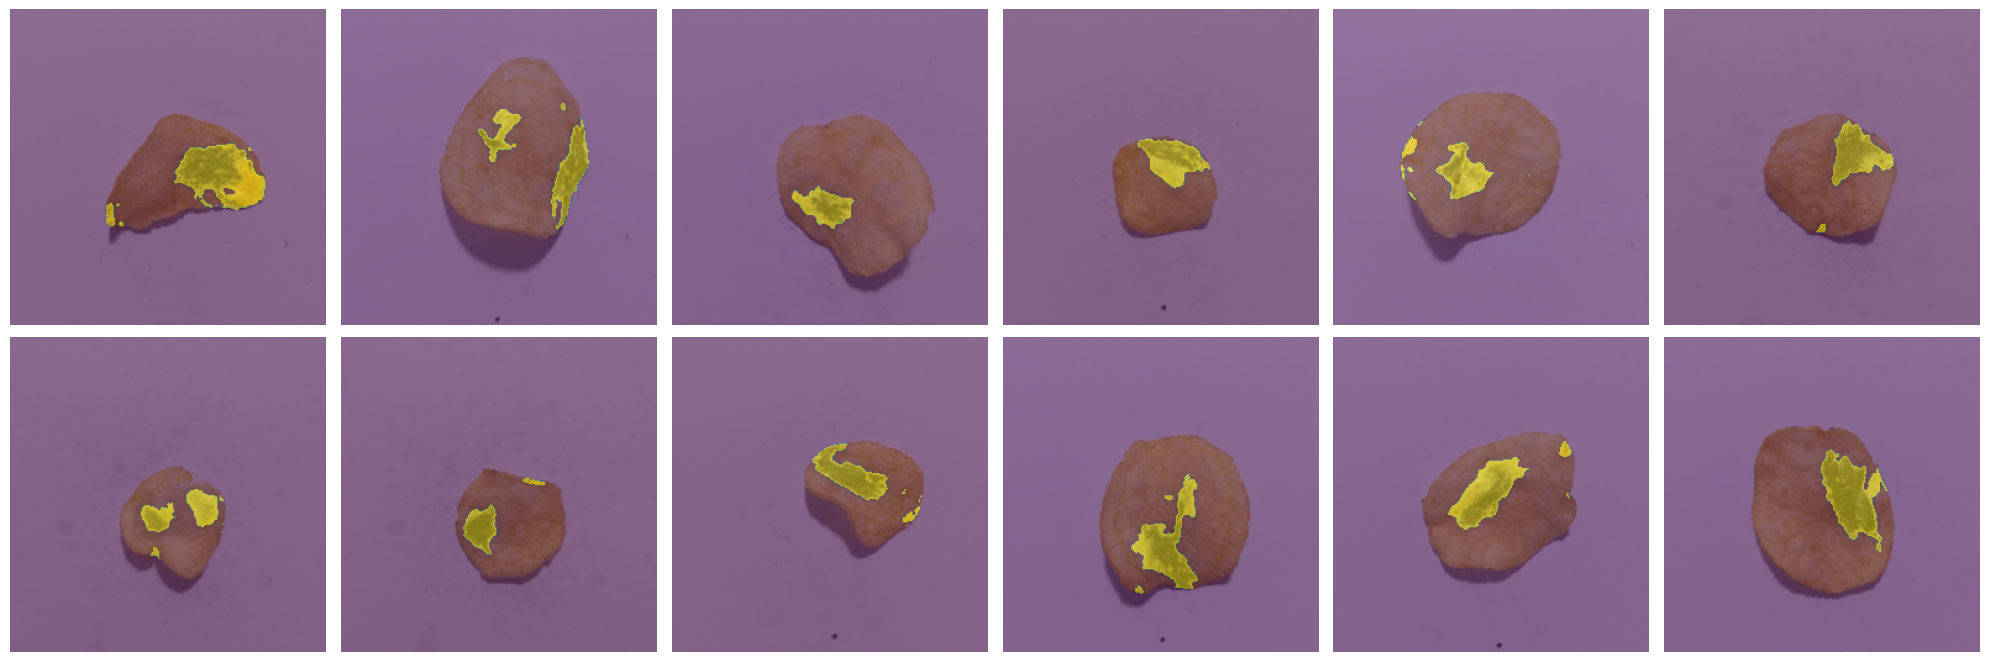

In [ ]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_test, preds.unsqueeze(1))